**Fourth Project Drowsiness detection**

In [1]:
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import numpy as np
import os

import numpy as np
import os, shutil
import pandas as pd

import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras import regularizers
from tensorflow.keras.constraints import MaxNorm
from scikeras.wrappers import KerasClassifier
from keras_preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from lime import lime_image
from skimage.segmentation import mark_boundaries

# fix random seed for reproducibility
seed = 42
tf.random.set_seed(seed)

import warnings
warnings.filterwarnings("ignore")

Let us try to preview some of our data

In [2]:
# Directory path
data_dir = 'data/'

In [3]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(data_dir, batch_size=4000)
images, labels = next(img_generator)

Found 4000 images belonging to 2 classes.


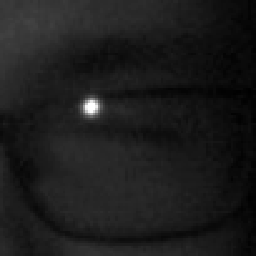

In [4]:
# Preview an image
array_to_img(images[0])

In [5]:
images.shape

(4000, 256, 256, 3)

In [6]:
images[0]

array([[[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       [[90., 90., 90.],
        [90., 90., 90.],
        [90., 90., 90.],
        ...,
        [48., 48., 48.],
        [48., 48., 48.],
        [48., 48., 48.]],

       ...,

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]],

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]],

       [[76., 76., 76.],
        [76., 76., 76.],
        [76., 76., 76.],
        ...,
        [51., 51., 51.],
        [51., 51., 51.],
        [51., 51., 51.]]

In [7]:
labels[0]

array([1., 0.], dtype=float32)

In [8]:
img_generator.class_indices

{'Closed_Eyes': 0, 'Open_Eyes': 1}

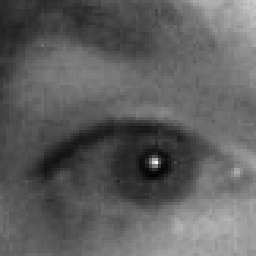

In [9]:
# Preview an image
array_to_img(images[4])

In [10]:
labels[6]

array([0., 1.], dtype=float32)

In [11]:
labels.shape

(4000, 2)

In [12]:
labels

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [13]:
labs=labels[:,1]

In [14]:
labs.shape

(4000,)

In [24]:
labs[1]

1.0

### Naive Model

In [26]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(
    data_dir, target_size=(32, 32), batch_size=4000)
images_32, labels_32 = next(img_generator)

Found 4000 images belonging to 2 classes.


In [27]:
labels_32=labels_32[:,1]

Let us find out if the classes are balanced:

In [28]:
print(f"number of non-zero: {np.count_nonzero(labels_32)}" )
print(f"number of zeros: {labels_32.size - np.count_nonzero(labels_32)}")

number of non-zero: 2000
number of zeros: 2000


Perfect, they are. Now let us create our first naive model:

In [29]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(32,32,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [32]:
X=images_32
y=labels_32

In [33]:
history = model.fit(X, y, epochs=15, batch_size=10, 
                        validation_split=0.2, verbose=1)

Epoch 1/15
320/320 [==============================] - 1s 5ms/step - loss: 0.6096 - acc: 0.7025 - val_loss: 0.5524 - val_acc: 0.7538
Epoch 2/15
320/320 [==============================] - 2s 5ms/step - loss: 0.5617 - acc: 0.7425 - val_loss: 0.5338 - val_acc: 0.7763
Epoch 3/15
320/320 [==============================] - 2s 7ms/step - loss: 0.5441 - acc: 0.7616 - val_loss: 0.5108 - val_acc: 0.7825
Epoch 4/15
320/320 [==============================] - 2s 5ms/step - loss: 0.5150 - acc: 0.7941 - val_loss: 0.4817 - val_acc: 0.8188
Epoch 5/15
320/320 [==============================] - 2s 5ms/step - loss: 0.4642 - acc: 0.8456 - val_loss: 0.3927 - val_acc: 0.9013
Epoch 6/15
320/320 [==============================] - 2s 5ms/step - loss: 0.3848 - acc: 0.8731 - val_loss: 0.3349 - val_acc: 0.9262
Epoch 7/15
320/320 [==============================] - 2s 5ms/step - loss: 0.2988 - acc: 0.9103 - val_loss: 0.2313 - val_acc: 0.9500
Epoch 8/15
320/320 [==============================] - 2s 6ms/step - loss: 0.

Defining some functions to evaluate the model:

In [35]:
def visualize_training_results(results):
#Extracting the history from the results of the model
    history = results.history
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
#Plotting Train and Validation Accuracy
    ax1.plot(history['val_acc'])
    ax1.plot(history['acc'])
#Setting legend, title and labels
    ax1.legend(['val_acc', 'acc'], loc='best')
    ax1.set_title('Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
#Plotting Train and Validation Loss    
    ax2.plot(history['val_loss'])
    ax2.plot(history['loss'])
#Setting legend, title and labels
    ax2.legend(['val_loss', 'loss'], loc='best')
    ax2.set_title('Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')

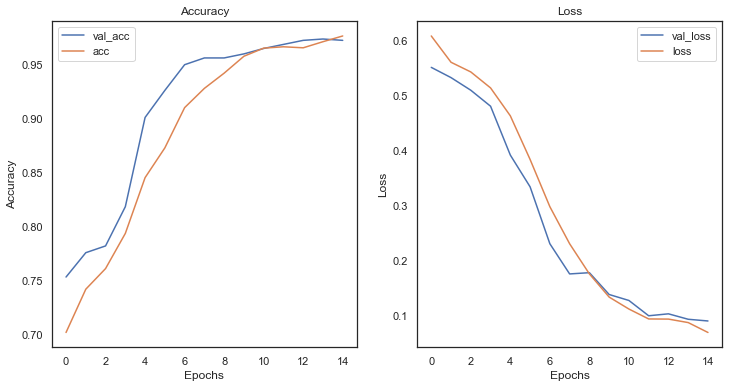

In [36]:
visualize_training_results(history)

In [37]:
def conf_matrix(model, trainX, trainy):
    seed = 42
    tf.random.set_seed(seed)
#    y_pred_prob = model.predict(trainX, verbose=0)
    # predict classes
    y_pred_clas = (model.predict(trainX) > 0.5).astype("float")
    # confusion matrix
    cnm = confusion_matrix(trainy, y_pred_clas)
    # To Normalize
    cnm = cnm.astype('float') / cnm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,5))
    sns.heatmap(cnm, annot=True, fmt='.2f', cmap="Oranges")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show(block=False)

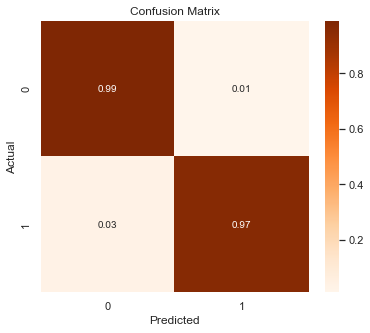

In [38]:
conf_matrix(model, X, y)

Let us see what happens increasing the size of the images:

In [39]:
# Get all the data in the directory data/validation (132 images), and reshape them
img_generator = ImageDataGenerator().flow_from_directory(
    data_dir, target_size=(64, 64), batch_size=4000)
images_64, labels_64 = next(img_generator)

Found 4000 images belonging to 2 classes.


In [40]:
labels_64=labels_64[:,1]

In [41]:
# create model
#Sequential: multiple layers built on top of each other

model = models.Sequential()
#Firs Convolutional Layer, with 3 neurons and 3X3 is the size of the filter
model.add(layers.Conv2D(3, (3, 3), activation='relu',
                        input_shape=(64,64,3)))
#MaxPooling with filter size 2 and stride 2
model.add(layers.MaxPooling2D(2,2))

#Flattening the last layer to be able to add the last Dense layer
model.add(layers.Flatten())
#Dense layer with 9 neurons (because of 9 classes)
model.add(layers.Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [42]:
X=images_64
y=labels_64

In [43]:
history = model.fit(X, y, epochs=15, batch_size=10, 
                        validation_split=0.2, verbose=1)

Epoch 1/15
320/320 [==============================] - 4s 12ms/step - loss: 6.3700 - acc: 0.7095 - val_loss: 0.1731 - val_acc: 0.9425
Epoch 2/15
320/320 [==============================] - 3s 10ms/step - loss: 0.1688 - acc: 0.9418 - val_loss: 0.1225 - val_acc: 0.9675
Epoch 3/15
320/320 [==============================] - 3s 11ms/step - loss: 0.0889 - acc: 0.9742 - val_loss: 0.0771 - val_acc: 0.9862
Epoch 4/15
320/320 [==============================] - 3s 10ms/step - loss: 0.0505 - acc: 0.9887 - val_loss: 0.0455 - val_acc: 0.9900
Epoch 5/15
320/320 [==============================] - 3s 11ms/step - loss: 0.0236 - acc: 0.9947 - val_loss: 0.0743 - val_acc: 0.9837
Epoch 6/15
320/320 [==============================] - 4s 13ms/step - loss: 0.0509 - acc: 0.9866 - val_loss: 0.0703 - val_acc: 0.9837
Epoch 7/15
320/320 [==============================] - 4s 13ms/step - loss: 0.0326 - acc: 0.9901 - val_loss: 0.0579 - val_acc: 0.9900
Epoch 8/15
320/320 [==============================] - 4s 14ms/step - 

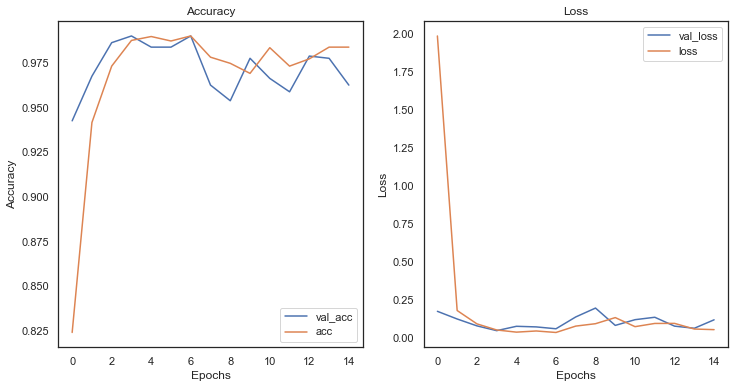

In [44]:
visualize_training_results(history)

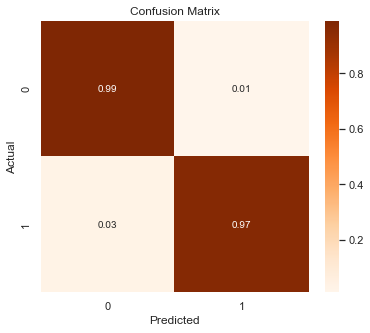

In [45]:
conf_matrix(model, X, y)